In [87]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import time
import matplotlib.pyplot as plt


In [88]:
DATA_PATH = r"D:\data\kaggle\ventilator-pressure-prediction\\"


sub = pd.read_csv(DATA_PATH + 'sample_submission.csv')
df_train = pd.read_csv(DATA_PATH + 'train.csv')
df_test = pd.read_csv(DATA_PATH + 'test.csv')

In [89]:
df_train = df_train.groupby('breath_id').agg(list).reset_index()
df_train

df_train_u_in = np.array(df_train['u_in'].values.tolist()).reshape(-1,80,1)
print(df_train_u_in.shape)

df_train_R = np.array(df_train['R'].values.tolist()).reshape(-1,80,1)
print(df_train_R.shape)

df_train_C = np.array(df_train['C'].values.tolist()).reshape(-1,80,1)
print(df_train_C.shape)

df_train_u_in = np.array(df_train['u_in'].values.tolist()).reshape(-1,80,1)
print(df_train_u_in.shape)

df_train_u_out = np.array(df_train['u_out'].values.tolist()).reshape(-1,80,1)
print(df_train_u_out.shape)

df_train_pressure = np.array(df_train['pressure'].values.tolist()).reshape(-1,80,1)
print(df_train_pressure.shape)

train_x = np.concatenate([df_train_u_in,df_train_R,df_train_C,df_train_u_out],axis=2)
print(train_x.shape)
train_y = df_train_pressure
print(train_y.shape)


In [ ]:
df_test = df_test.groupby('breath_id').agg(list).reset_index()
df_test

df_test_u_in = np.array(df_test['u_in'].values.tolist()).reshape(-1,80,1)
print(df_test_u_in.shape)

df_test_R = np.array(df_test['R'].values.tolist()).reshape(-1,80,1)
print(df_test_R.shape)

df_test_C = np.array(df_test['C'].values.tolist()).reshape(-1,80,1)
print(df_test_C.shape)

df_test_u_in = np.array(df_test['u_in'].values.tolist()).reshape(-1,80,1)
print(df_test_u_in.shape)

df_test_u_out = np.array(df_test['u_out'].values.tolist()).reshape(-1,80,1)
print(df_test_u_out.shape)



test_x = np.concatenate([df_test_u_in,df_test_R,df_test_C,df_test_u_out],axis=2)
print(test_x.shape)



(50300, 80, 1)
(50300, 80, 1)
(50300, 80, 1)
(50300, 80, 1)
(50300, 80, 1)
(50300, 80, 4)


In [ ]:
class My_data_y_Dataset(Dataset):
    def __init__(self, data, labels):
        self.data = data  # 输入数据数组，形状为(670, 10, 1)
        self.labels = labels  # 对应标签数组，形状为(670, 1)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx], dtype=torch.float)
        y = torch.tensor(self.labels[idx], dtype=torch.float)
        return x, y
    
class My_data_Dataset(Dataset):
    def __init__(self, data):
        self.data = data  # 输入数据数组，形状为(670, 10, 1)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx], dtype=torch.float)
        return x
# dataset = MyDataset(data, labels)
train_all_dataset = My_data_y_Dataset(train_x, train_y)

train_dataset, val_dataset = torch.utils.data.random_split(train_all_dataset, [0.9, 0.1])

test_dataset = My_data_Dataset(test_x)


In [ ]:
# 注意：时间序列数据不能shuffle
train_loader = DataLoader(
    train_dataset,
    batch_size=50,
    shuffle=False,
    drop_last=True
)
# 注意：时间序列数据不能shuffle
val_loader = DataLoader(
    val_dataset,
    batch_size=50,
    shuffle=False,
    drop_last=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=50,
    shuffle=False,
    drop_last=True
)

In [ ]:
class RNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        # [batch,seq_len,input_size]
        # [50,80,4]
        self.rnn = nn.RNN(
            input_size = 4, 
            hidden_size = 20, 
            num_layers = 1, 
            batch_first=True, 
        )
        self.fc = nn.Sequential(
            nn.ReLU(),
            nn.Linear(20,5),
            nn.ReLU(),
            nn.Linear(5,1)
        )
    # hidden_prev  [num_layers,seq_len,hidden_size]
    def forward(self,x,hidden_prev):
        # print(x.shape)

        out, hidden_prev = self.rnn(x, hidden_prev)
        # print(out.shape)
        
        
        out = self.fc(out) #[50, 80, 1]
        # print(out.shape)
        
        return out, hidden_prev
        

In [ ]:
device="cuda"
model = RNNModel()
model = model.to(device)

In [ ]:
temp = torch.tensor(np.arange(0,50*80*4).reshape(50,80,4),dtype=torch.float)
print(temp.shape)
hidden_prev = torch.tensor(np.zeros([1,50,20]),dtype=torch.float)
hidden_prev = hidden_prev.to(device)
print(hidden_prev.shape)

torch.Size([50, 80, 4])
torch.Size([1, 50, 20])


In [ ]:
epochs = 3
lr = 0.00001

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr = lr)

In [ ]:
train_loss_list = []
val_loss_list = []
for epoch in range(epochs):

    train_loss = 0
    start_time = time.time()
    # train
    for id,(data,y) in enumerate(train_loader):
        # print(id,data.shape,y.shape)
        data,y = data.to(device),y.to(device)
        pred , _ = model(data,hidden_prev)
        # print(pred.shape,y.shape)
        loss = criterion(pred, y)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss / len(train_loader)
    train_loss_list.append(train_loss.cpu().detach().numpy())
    # val
    val_loss = 0
    with torch.no_grad():
        for id,(data,y) in enumerate(val_loader):
            # print(id,data.shape,y.shape)
            data,y = data.to(device),y.to(device)
            pred , _ = model(data,hidden_prev)
            # print(pred.shape,y.shape)
            loss = criterion(pred, y)
            val_loss += loss / len(val_loader)

        val_loss_list.append(val_loss.cpu().detach().numpy())
        end_time = time.time() - start_time
    print(f'training epoch:{epoch:2d}/{epochs:2d} train_loss:{train_loss:.4f} val_loss:{val_loss:.4f} time:{end_time}')   

training epoch: 0/ 3 train_loss:183.7957 val_loss:179.5474 time:10.887635469436646
training epoch: 1/ 3 train_loss:179.0912 val_loss:173.8221 time:9.117713928222656
training epoch: 2/ 3 train_loss:173.1967 val_loss:168.3015 time:9.545637130737305


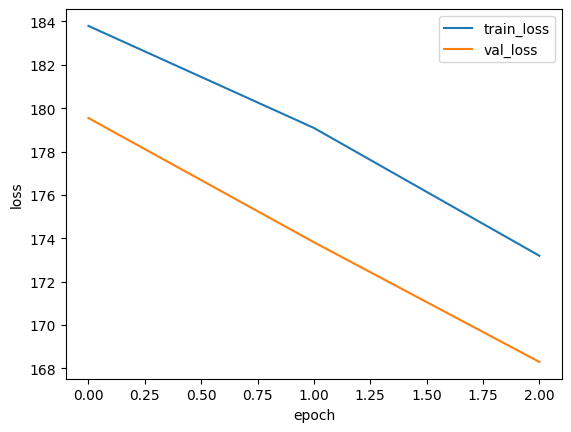

<Figure size 640x480 with 0 Axes>

In [ ]:
# 保存loss图像
plt.plot(range(len(train_loss_list)), train_loss_list, label="train_loss")
plt.plot(range(len(val_loss_list)), val_loss_list, label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()
plt.clf()

4024000


<function matplotlib.pyplot.show(close=None, block=None)>

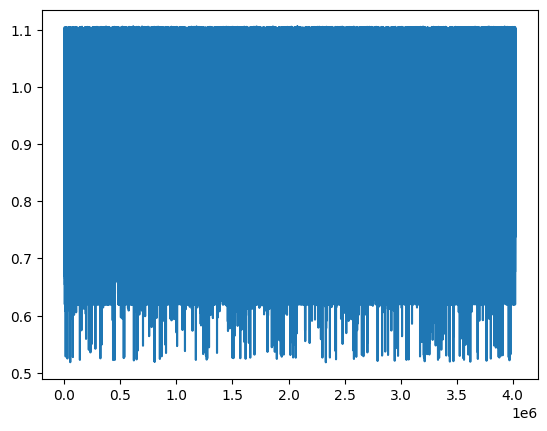

In [ ]:
result = []
with torch.no_grad():
    for id,(data) in enumerate(test_loader):
        # print(id,data.shape,y.shape)
        data = data.to(device)
        pred , _ = model(data,hidden_prev)
        pred = pred.cpu().detach().numpy().reshape(50,80).reshape(50*80)
        result.extend(pred)
print(len(result))
        
plt.plot(result)
plt.show

In [ ]:
sub.head(5)

,id,pressure
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [ ]:
sub.describe()

,id,pressure
count,4.024000e+06,4024000.0
mean,2.012000e+06,0.0
std,1.161629e+06,0.0
min,1.000000e+00,0.0
25%,1.006001e+06,0.0
50%,2.012000e+06,0.0
75%,3.018000e+06,0.0
max,4.024000e+06,0.0


In [ ]:
sub['pressure'] = result

In [ ]:
sub.head(5)

,id,pressure
0,1,0.669762
1,2,0.937317
2,3,0.966778
3,4,0.945335
4,5,0.898531


In [ ]:
sub.to_csv('submission.csv', index=False)
